In [18]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import importlib
importlib.import_module("utils")
from utils.prepare_dataset import prepare_dataset_mnist

In [5]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_GPU = True if torch.cuda.is_available() else "cpu"

In [3]:
# max_seq_len = 64
# batch_size = 64
# dataset_size = 2000
# with_mask = False

# train_tokens, train_labels, train_mask, val_tokens, val_labels, val_mask = prepare_dataset_mnist(file="dataset/building_shapes_5010.csv",
#                                                                                                  with_mask=with_mask,
#                                                                                                  split_ratio=0.2,
#                                                                                                  dataset_size=dataset_size,
#                                                                                                  max_seq_len=max_seq_len,
#                                                                                                  train=True)

# # train_tokens, val_tokens = train_tokens[:, :, :2].contiguous(), val_tokens[:, :, :2].contiguous()

# train_loader = DataLoader(TensorDataset(train_tokens, train_labels), batch_size=batch_size, shuffle=True)

In [48]:
# max_seq_len = 64
# batch_size = 64
# dataset_size = None
# with_mask = False

# train_tokens, train_labels, train_mask, val_tokens, val_labels, val_mask = prepare_dataset_mnist(file="dataset/mnist_polygon_train_10k.csv",
#                                                                                                  with_mask=with_mask,
#                                                                                                  split_ratio=0.2,
#                                                                                                  dataset_size=dataset_size,
#                                                                                                  max_seq_len=max_seq_len,
#                                                                                                  train=True)

# # test_tokens, test_labels, test_mask = prepare_dataset_mnist(file="dataset/mnist_polygon_test_2k.csv",
# #                                                             with_mask=with_mask,
# #                                                             max_seq_len=max_seq_len,
# #                                                             dataset_size=500,
# #                                                             train=False)

# # train_loader = DataLoader(TensorDataset(train_tokens, train_labels), batch_size=batch_size, shuffle=True)

In [8]:
import numpy as np

max_seq_len = 64
batch_size = 64

loaded = np.load("../dataset/synthetic_simple_2k.npz")
train_tokens = loaded["geoms"]
wkts = loaded["wkts"]

train_tokens = torch.tensor(train_tokens, dtype=torch.float32)
train_labels = torch.zeros((train_tokens).shape[0])

train_loader = DataLoader(TensorDataset(train_tokens, train_labels), batch_size=batch_size, shuffle=True)

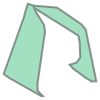

In [9]:
from utils.vector2shape import reverse_vector_polygon
reverse_vector_polygon(train_tokens[11])

In [ ]:
train_tokens[10]

In [13]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_dim, max_seq_len):
        super().__init__()

        pe = torch.zeros(max_seq_len, emb_dim)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_dim, 2).float() * -(math.log(10000.0) / emb_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        if emb_dim % 2 == 0:
            pe[:, 1::2] = torch.cos(position * div_term)
        else:
            pe[:, 1::2] = torch.cos(position * div_term)[:, :-1] # Avoid dismatch dimension for odd d_model
        self.register_buffer('pe', pe.unsqueeze(0))
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]
    

class Pae(nn.Module):
    def __init__(self, fea_dim=7, d_model=36, num_heads=6, ffn_dim=32, dropout=0.5, num_layers=1, max_seq_len=64):
        super().__init__()

        self.cls_emb = nn.Parameter(torch.randn(1, 1, d_model))
        self.enc_layer1 = nn.Sequential(nn.TransformerEncoderLayer(d_model=d_model, nhead=4, dim_feedforward=ffn_dim,
                                                                    dropout=dropout, batch_first=True),
                                        nn.Linear(d_model, 18),
                                        nn.LayerNorm(18)
                                        )
        
        self.enc_layer2 = nn.Sequential(nn.TransformerEncoderLayer(d_model=36, nhead=6, dim_feedforward=ffn_dim,
                                                                    dropout=dropout, batch_first=True),
                                        nn.Linear(36, 18),
                                        nn.LayerNorm(18)
                                        )
        
        self.enc_layer3 = nn.Sequential(nn.TransformerEncoderLayer(d_model=36, nhead=9, dim_feedforward=ffn_dim,
                                                                    dropout=dropout, batch_first=True),
                                        nn.Flatten(),
                                        nn.Linear(16*36, 64),
                                        nn.LayerNorm(64)
                                        )

        
        self.dec_layer1 = nn.Sequential(
                                        nn.TransformerEncoderLayer(d_model=36, nhead=9, dim_feedforward=ffn_dim,
                                                                    dropout=dropout, batch_first=True))
        
        self.dec_layer2 = nn.Sequential(nn.Linear(18, 36),
                                        nn.LayerNorm(36),
                                        nn.TransformerEncoderLayer(d_model=36, nhead=6, dim_feedforward=ffn_dim,
                                                                    dropout=dropout, batch_first=True))
        
        self.dec_layer3 = nn.Sequential(nn.Linear(18, d_model),
                                        nn.LayerNorm(36),
                                        nn.TransformerEncoderLayer(d_model=d_model, nhead=4, dim_feedforward=ffn_dim,
                                                                    dropout=dropout, batch_first=True),
)

        self.enc_layers = [self.enc_layer1, self.enc_layer2, self.enc_layer3]
        self.dec_layers = [self.dec_layer1, self.dec_layer2, self.dec_layer3]

        
        self.pos_emb = PositionalEncoding(d_model, max_seq_len)
        self.rec = nn.Linear(64, 16*36)
        self.project = nn.Linear(fea_dim, d_model)
        self.remap = nn.Linear(d_model, fea_dim)

        self.mse_loss_func = F.mse_loss
        self.meta_loss_func = nn.CrossEntropyLoss()
        self.render_loss_func = nn.BCELoss()

    def forward(self, x, mask=None):
        input = self.project(x)
        input = self.pos_emb(input)

        hidden = input
        for i, enc_layer in enumerate(self.enc_layers):
            hidden = enc_layer(hidden)
            if i != len(self.enc_layers)-1:
                hidden = hidden.view(hidden.size(0), hidden.size(1)//2, -1) # flatten to decrese seq_len and increase fea dim

        decoded = self.rec(hidden).reshape(input.size(0), 16, 36)
        for i, dec_layer in enumerate(self.dec_layers):
            if i != 0:
                decoded = decoded.view(decoded.size(0), decoded.size(1)*2, -1)
            decoded = dec_layer(decoded)
            
        decoded = self.remap(decoded)

        coord_output = decoded[:, :, :2]
        meta_output1 = decoded[:, :, 2:4]
        meta_output2 = decoded[:, :, 4:]
        target_meta1 = torch.argmax(x[:, :, 2:4], dim=-1) # inner or outer points
        target_meta2 = torch.argmax(x[:, :, 4:], dim=-1) # render one-hot code
        coord_loss = self.mse_loss_func(coord_output, x[:, :, :2], reduction="none")
        coord_loss = coord_loss.sum(dim=[1, 2]).mean(dim=[0])
        # 2 is inner or outer one-hot vocab size, 3 is render one-hot vocab size
        meta_loss1 = self.meta_loss_func(meta_output1.contiguous().view(-1, 2), target_meta1.contiguous().view(-1))
        meta_loss2 = self.meta_loss_func(meta_output2.contiguous().view(-1, 3), target_meta2.contiguous().view(-1))

        meta_indices1 = torch.argmax(meta_output1, dim=-1)
        meta_indices2 = torch.argmax(meta_output2, dim=-1)
        output = torch.cat([coord_output, nn.functional.one_hot(meta_indices1, 2), nn.functional.one_hot(meta_indices2, 3)], dim=-1)
        
        # return hidden, output, coord_loss*0.25 + (meta_loss1 + meta_loss2)*0.75
        return hidden, output, coord_loss + meta_loss1 + meta_loss2

In [14]:
pae = Pae(fea_dim=7, ffn_dim=64, dropout=0.1)

if USE_GPU:
    pae = pae.to(device)

optimizer = optim.Adam(pae.parameters(), lr=0.004, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001)

num_epoch = 100
for epoch in range(num_epoch):
    pae.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        train_hidden, train_outputs, loss = pae(inputs)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    train_loss = total_loss/len(train_loader)

    pae.eval()
    with torch.no_grad():
        val_hidden, val_outputs, loss = pae(train_tokens)
        val_loss = loss.item()
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

pae.eval()
with torch.no_grad():
    test_hidden, test_outputs, loss = pae(train_tokens)
    test_loss = loss.item()
print(f"Test Loss: {test_loss}")

Epoch 1, Train Loss: 16.53840520977974, Val Loss: 11.056057929992676
Epoch 2, Train Loss: 11.097036838531494, Val Loss: 10.833304405212402
Epoch 3, Train Loss: 10.90701973438263, Val Loss: 11.04523754119873
Epoch 4, Train Loss: 10.899464696645737, Val Loss: 10.76543140411377
Epoch 5, Train Loss: 10.809211999177933, Val Loss: 10.73440170288086
Epoch 6, Train Loss: 10.800668478012085, Val Loss: 10.811015129089355
Epoch 7, Train Loss: 10.833011418581009, Val Loss: 10.823600769042969
Epoch 8, Train Loss: 10.835951089859009, Val Loss: 10.7130708694458
Epoch 9, Train Loss: 10.811006337404251, Val Loss: 10.649035453796387
Epoch 10, Train Loss: 10.748643308877945, Val Loss: 10.755422592163086
Epoch 11, Train Loss: 10.667976349592209, Val Loss: 9.08767032623291
Epoch 12, Train Loss: 4.702762916684151, Val Loss: 3.850449562072754
Epoch 13, Train Loss: 3.6203693002462387, Val Loss: 3.1110048294067383
Epoch 14, Train Loss: 2.8893243223428726, Val Loss: 2.564697504043579
Epoch 15, Train Loss: 2.527

KeyboardInterrupt: 

In [40]:
# torch.save(pae.state_dict(), 'weights/synthetic_simple_2k_transf.pth')
pae.load_state_dict(torch.load("weights/synthetic_simple_2k_transf.pth"))

<All keys matched successfully>

Test Loss: 0.029933234676718712


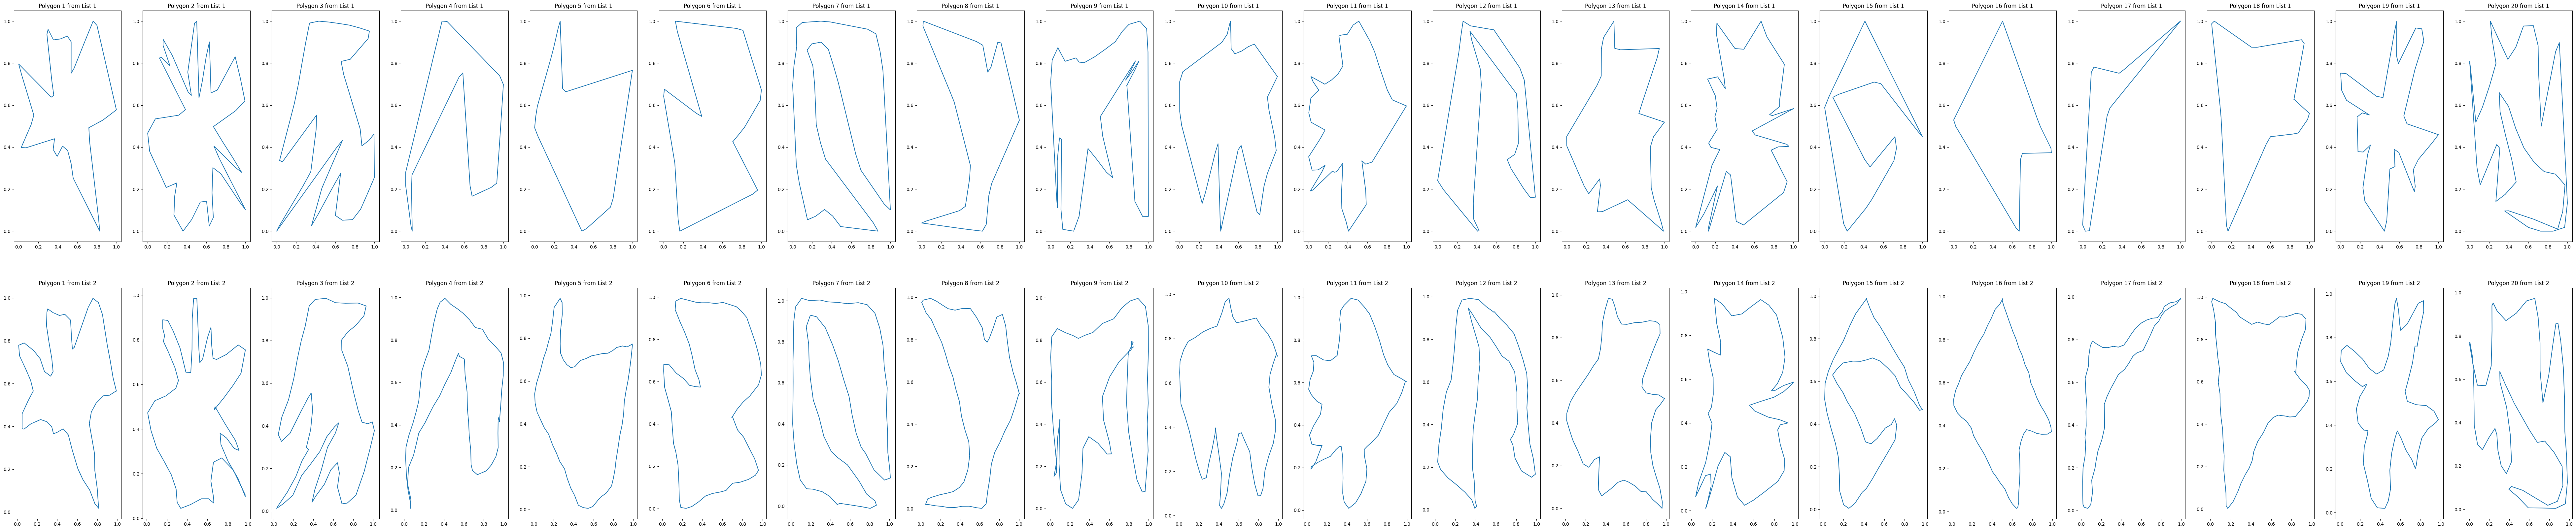

In [15]:
from utils.vector2shape import reverse_vector_polygon
import matplotlib.pyplot as plt

pae.eval()
with torch.no_grad():
    test_hidden, test_outputs, loss = pae(train_tokens)
    test_loss = loss.item()
print(f"Test Loss: {test_loss}")

num_samples = 20
show_tokens = train_tokens[:num_samples]
show_outputs = test_outputs[:num_samples]

ori_polygons = [reverse_vector_polygon(token) for token in show_tokens]
new_polygons = [reverse_vector_polygon(token) for token in show_outputs]

# Create a figure with subplots for each polygon
fig, axs = plt.subplots(2, num_samples, figsize=(5*num_samples, 20))

# Plot polygons from the first list
for i, polygon in enumerate(ori_polygons):
    axs[0, i].set_title('Polygon {} from List 1'.format(i+1))
    x, y = polygon.exterior.xy
    axs[0, i].plot(x, y)
    holes_x = [[coord[0] for coord in interior.coords] for interior in polygon.interiors]
    holes_y = [[coord[1] for coord in interior.coords] for interior in polygon.interiors]
    if holes_x:
        for hole_x, hole_y in zip(holes_x, holes_y):
            axs[0, i].plot(hole_x, hole_y)

# Plot polygons from the second list
for i, polygon in enumerate(new_polygons):
    axs[1, i].set_title('Polygon {} from List 2'.format(i+1))
    x, y = polygon.exterior.xy
    axs[1, i].plot(x, y)
    holes_x = [[coord[0] for coord in interior.coords] for interior in polygon.interiors]
    holes_y = [[coord[1] for coord in interior.coords] for interior in polygon.interiors]
    if holes_x:
        for hole_x, hole_y in zip(holes_x, holes_y):
            axs[1, i].plot(hole_x, hole_y)

# Show the plot
plt.show()

In [42]:
from utils.embeding_evaluate import compute_NN, compute_FT, compute_ST

pae.eval()
with torch.no_grad():
    test_hidden, test_outputs, loss = pae(train_tokens)
    test_loss = loss.item()
print(f"Test Loss: {test_loss}")

show_hidden = test_hidden.reshape(test_hidden.size(0), -1)
show_labels = train_labels

"Embedding", compute_NN(show_hidden, show_labels), compute_FT(show_hidden, show_labels), compute_ST(show_hidden, show_labels)

Test Loss: 1.641058325767517


('Embedding', 0.943125, 0.5106295130300547, 0.6346466227389143)

In [43]:
from utils.embeding_evaluate import compute_NN, compute_FT, compute_ST

show_hidden = train_tokens.reshape(train_tokens.size(0), -1)
show_labels = train_labels

"Original", compute_NN(show_hidden, show_labels), compute_FT(show_hidden, show_labels), compute_ST(show_hidden, show_labels)

('Original', 0.921875, 0.48278103769007996, 0.6189769244956509)

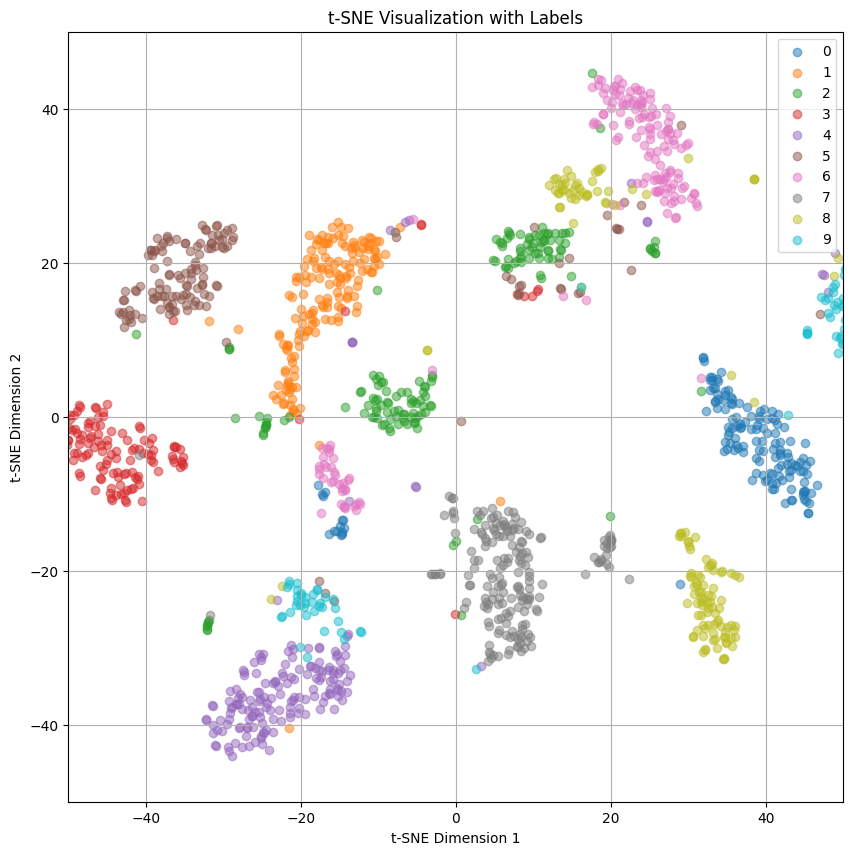

In [44]:
show_hidden = test_hidden.view(test_hidden.size(0), -1)
show_labels = train_labels

# show_hidden = train_tokens.view(train_tokens.size(0), -1).detach().numpy()
# show_labels = train_labels


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(show_hidden)

plt.figure(figsize=(10, 10))

# Plot each class separately
for label in np.unique(show_labels):
    indices = show_labels == label
    plt.scatter(projections[indices, 0], projections[indices, 1], label=label, alpha=0.5)

plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.title('t-SNE Visualization with Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
with torch.no_grad():
    cls_train_hidden = pae(train_tokens)[0].reshape(train_tokens.size(0), -1)
    cls_val_hidden = pae(val_tokens)[0].reshape(val_tokens.size(0), -1)

    # tsne = PCA(n_components=64, random_state=0)
    # train_hidden = torch.tensor(tsne.fit_transform(train_hidden), dtype=torch.float32)
    # val_hidden = torch.tensor(tsne.transform(val_hidden), dtype=torch.float32)

# cls_train_hidden = train_tokens.reshape(train_tokens.size(0), -1)
# cls_val_hidden = val_tokens.reshape(val_tokens.size(0), -1)

cls_train_loader = DataLoader(TensorDataset(cls_train_hidden, train_labels), batch_size=32, shuffle=True)

In [47]:
# Define the classifier
class Classifier(nn.Module):
    def __init__(self, input_size, dense_size, num_classes, dropout):
        super().__init__()
        self.dense1 = nn.Linear(input_size, dense_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_size, num_classes)

    def forward(self, x):
        x = self.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        # # Linear probing
        # x = self.dense1(x)
        return x
    
classifier = Classifier(cls_train_hidden.size(1), 128, 10, 0.0)

if USE_GPU:
    classifier = classifier.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.004)
# optimizer = optim.Adam(classifier.parameters(), lr=0.004, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.001)
# optimizer = optim.Adam(classifier.parameters(), lr=0.004, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.001)

num_epochs = 100

def train(model, loader):
    model.eval()
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_x, batch_y in loader:
        if USE_GPU:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, dim=-1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    train_loss /= len(loader)
    train_acc = correct / total
    return train_loss, train_acc

def evaluate(model, tokens, labels):
    model.eval()
    with torch.no_grad():
        if USE_GPU:
            tokens, labels = tokens.to(device), labels.to(device)
        outputs = model(tokens)
        eval_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, dim=-1)
        eval_acc = (predicted == labels).sum().item() / labels.size(0)
    return eval_loss, eval_acc

for epoch in range(num_epochs):
    train_loss, train_acc = train(classifier, cls_train_loader)
    val_loss, val_acc = evaluate(classifier, cls_val_hidden, val_labels)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss}, Train Acc {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}")


# # Test
# test_loss, test_acc = evaluate(classifier, test_loader)
# print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

Epoch: 1, Train Loss: 0.753072040528059, Train Acc 0.79125, Val Loss: 0.446163535118103, Val Acc: 0.8825
Epoch: 2, Train Loss: 0.3068625220656395, Train Acc 0.91375, Val Loss: 0.3961648941040039, Val Acc: 0.8825
Epoch: 3, Train Loss: 0.226855226829648, Train Acc 0.934375, Val Loss: 0.3492465615272522, Val Acc: 0.9075
Epoch: 4, Train Loss: 0.1770968447625637, Train Acc 0.939375, Val Loss: 0.35819312930107117, Val Acc: 0.915
Epoch: 5, Train Loss: 0.14336601279675962, Train Acc 0.954375, Val Loss: 0.34061118960380554, Val Acc: 0.915
Epoch: 6, Train Loss: 0.1093330467864871, Train Acc 0.968125, Val Loss: 0.3830065131187439, Val Acc: 0.91
Epoch: 7, Train Loss: 0.0848499297350645, Train Acc 0.97625, Val Loss: 0.44155433773994446, Val Acc: 0.895
Epoch: 8, Train Loss: 0.07219192644581199, Train Acc 0.980625, Val Loss: 0.390291303396225, Val Acc: 0.9125
Epoch: 9, Train Loss: 0.06383921903325245, Train Acc 0.981875, Val Loss: 0.41558074951171875, Val Acc: 0.915
Epoch: 10, Train Loss: 0.059877511